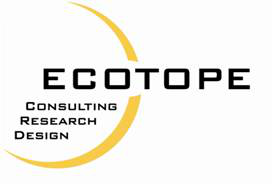

In [1]:
from IPython.display import Image
#Image(filename='ecotope_color_logo.png') 
Image(filename = "ecotope_color_logo.png", width=251.8, height=55.5)

In [2]:
import pandas as pd
import numpy as np

import math
import sqlite3
import os

import matplotlib as plt
import seaborn as sns

In [3]:
## FILE PATH
# define path for database file, you will have to edit to your repository path or it will NOT work
path = "C:\\Users\\scott\\github\\OCCE_HVAC_Comparison\\"
filename = "NEAA_final_dataset.db"

# make connection
con = sqlite3.connect(os.path.join(path, filename))

# OUTDOOR AIR LOAD

In [4]:
# Inputs
t_oa_winter = {'Portland':25.0, 'Albany':24.8, 'Eugene':22.8, 'Bend':5.2, 'Salem':23.7,
               'Stayton':23.7, 'Beaverton':25.0, 'Newberg':25.0, 'Medford':22.8, 'Tualatin':25.0,
               'Sherwood':25.0, 'Corvallis':24.8, 'Helix':8.2, 'Crescent':5.2} # outdoor air temperature at Heating Design Setpoint
t_oa_summer = {'Portland':91.2, 'Albany':92.7, 'Eugene':91.8, 'Bend':93.2, 'Salem':92.1,
               'Stayton':92.1, 'Beaverton':91.2, 'Newberg':91.2, 'Medford':99.0, 'Tualatin':91.2,
               'Sherwood':91.2, 'Corvallis':92.7, 'Helix':96.8, 'Crescent':93.2} # outdoor air temperature at Heating Design Setpoint
t_stpt = 72 # room setpoint temperatures

# df rows to print
row = 5

In [5]:
## cfm/sf calculation

# text for OA sql query
sql_query = "SELECT SPACES.siteid, SITE_DETAILS.city, SPACES.[cfm/sf], SPACES.totalmeasurement, SPACES.conditionedmeasurement " #
sql_query += "FROM SPACES "
sql_query += "LEFT JOIN SITE_DETAILS "
sql_query += "ON SPACES.siteid = SITE_DETAILS.siteid"

OA_LOADS = pd.read_sql_query(sql_query, con)

OA_LOADS = OA_LOADS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

# estimate outdoor air
OA_LOADS['OutdoorAir [cfm]'] = (OA_LOADS['cfm/sf'] * OA_LOADS['totalmeasurement'])

# calculate heating load from OA
cooling = []
heating = []
for i in range(0,len(OA_LOADS)):
    cooling.append((1.08 * OA_LOADS['OutdoorAir [cfm]'][i] * (t_oa_summer[OA_LOADS['city'][i]] - t_stpt)) / 1000)
    heating.append((1.08 * OA_LOADS['OutdoorAir [cfm]'][i] * (t_stpt - t_oa_winter[OA_LOADS['city'][i]])) / 1000)
    
# append lists to df
OA_LOADS['OA Heating Load [kBtu]'] = heating
OA_LOADS['OA Cooling Load [kBtu]'] = cooling

OA_LOADS = OA_LOADS.groupby('siteid').sum()

In [6]:
## Outdoor Air Loads / Area

# estimate area
OA_LOADS['EstAreaSF'] = OA_LOADS.loc[:, ['conditionedmeasurement', 
                                     'totalmeasurement']].min(axis = 1)

OA_LOADS['OA Heating [Kbtu/sf]'] = OA_LOADS['OA Heating Load [kBtu]'] / OA_LOADS['EstAreaSF']
OA_LOADS['OA Cooling [Kbtu/sf]'] = OA_LOADS['OA Cooling Load [kBtu]'] / OA_LOADS['EstAreaSF']

In [7]:
OA_LOADS.head(row)

,cfm/sf,totalmeasurement,conditionedmeasurement,OutdoorAir [cfm],OA Heating Load [kBtu],OA Cooling Load [kBtu],EstAreaSF,OA Heating [Kbtu/sf],OA Cooling [Kbtu/sf]
siteid,,,,,,,,,
100016,0.64,172055.18,123604.0,13663.52,693.560275,283.326751,123604.0,0.005611,0.002292
100201,0.93,43059.00,43059.0,3390.57,172.105333,70.306860,43059.0,0.003997,0.001633
101127,1.36,53564.00,49553.0,6162.10,312.788196,127.777306,49553.0,0.006312,0.002579
101959,0.82,63555.00,63555.0,6597.70,334.899252,136.809907,63555.0,0.005269,0.002153
102217,0.23,502651.00,108792.0,25022.16,1275.529628,559.395409,108792.0,0.011724,0.005142


In [8]:
folder = 'RESULTS\\'
name = 'OA_LOADS.csv'
OA_LOADS.to_csv(path + folder + name)

## [CFM/SF] Loads

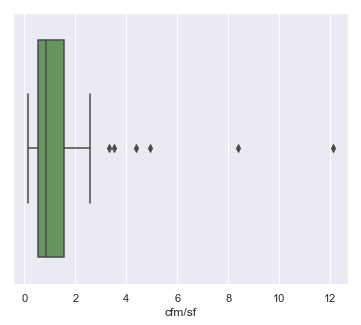

In [9]:
sns.set(rc={'figure.figsize':(6,5)})
ax = sns.boxplot(x=OA_LOADS["cfm/sf"], color=sns.xkcd_rgb["muted green"])

## Outdoor Air Heating Loads

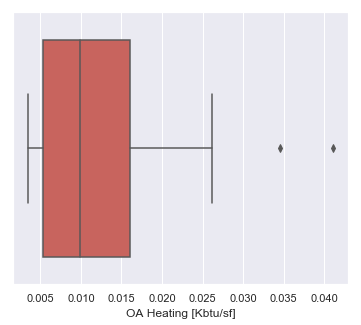

In [10]:
ax = sns.boxplot(x=OA_LOADS['OA Heating [Kbtu/sf]'], color=sns.xkcd_rgb["pale red"])

## Outdoor Air Cooling Loads

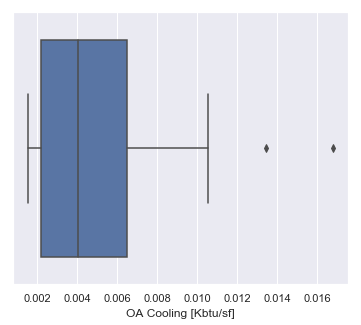

In [11]:
ax = sns.boxplot(x=OA_LOADS['OA Cooling [Kbtu/sf]'])

# COOLING LOAD

In [12]:
## VARIABLES DEFINED
# Design Day temperature by city
t_oa_winter = {'Portland':25.0, 'Albany':24.8, 'Eugene':22.8, 'Bend':5.2, 'Salem':23.7,
               'Stayton':23.7, 'Beaverton':25.0, 'Newberg':25.0, 'Medford':22.8, 'Tualatin':25.0,
               'Sherwood':25.0, 'Corvallis':24.8, 'Helix':8.2, 'Crescent':5.2} # outdoor air temperature at Heating Design Setpoint
t_oa_summer = {'Portland':91.2, 'Albany':92.7, 'Eugene':91.8, 'Bend':93.2, 'Salem':92.1,
               'Stayton':92.1, 'Beaverton':91.2, 'Newberg':91.2, 'Medford':99.0, 'Tualatin':91.2,
               'Sherwood':91.2, 'Corvallis':92.7, 'Helix':96.8, 'Crescent':93.2} # outdoor air temperature at Heating Design Setpoint
t_stpt = 72 # room setpoint temperatures

# variables used in CLTD conduction/convection heat gain
cltd_start=40 # starting assumed CLTD for walls and roof
k=1
f=1

# varaibles used for CLF solar heat gain
clf = 0.32 # cooling load factor
shgf = 211 # max solar heat gain factor

# rows to show
row = 15

In [13]:
## QUERY
# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.siteid, SITE_DETAILS.totalconditionedfloorareaofallbuildings, SITE_DETAILS.totalgrossfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.[detail.primarybuildingtypecategory], SITE_DETAILS.city, OVERALL_UA.[ua.total], '
sql_query += 'COOLINGLOADENV.WallNorth, COOLINGLOADENV.WallSouth, COOLINGLOADENV.WallEast, COOLINGLOADENV.WallWest, '
sql_query += 'COOLINGLOADENV.WindowWest, COOLINGLOADENV.SC, COOLINGLOADENV.LPD, COOLINGLOADENV.EPD, COOLINGLOADENV.PPL '
sql_query += 'FROM SITE_DETAILS '
sql_query += 'LEFT JOIN OVERALL_UA '
sql_query += 'ON SITE_DETAILS.siteid = OVERALL_UA.siteid '
sql_query += 'LEFT JOIN COOLINGLOADENV '
sql_query += 'ON SITE_DETAILS.siteid = COOLINGLOADENV.siteid'

ENV_GAIN = pd.read_sql_query(sql_query, con)
ENV_GAIN = ENV_GAIN.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

#ENV_GAIN.head(row)

In [14]:
## ENVELOPE GAIN - CONDUCTION AND CONVECTION

# CLTD adjustments
# Calculate weighted wall LM
lmN = 3
lmE = 1
lmS = 7
lmW = 1

lm_list = []
cltd_list = []
for i in range(0, len(ENV_GAIN)):
    
    # Calculate LM
    lm = ((ENV_GAIN['WallNorth'][i]*lmN + ENV_GAIN['WallSouth'][i]*lmS + 
                 ENV_GAIN['WallEast'][i]*lmE + ENV_GAIN['WallWest'][i]*lmW) / 
                 (ENV_GAIN['WallNorth'][i] + ENV_GAIN['WallSouth'][i] + 
                  ENV_GAIN['WallEast'][i] + ENV_GAIN['WallWest'][i]))
    lm_list.append(lm)

    # Calculate adjusted CLTD
    cltd = ((cltd_start + lm) * k + (78 - 72) + (t_oa_summer[ENV_GAIN['city'][i]] - 85)) * f
    cltd_list.append(cltd)
    
# append lists to df
ENV_GAIN['LM'] = lm_list
ENV_GAIN['CLTD'] = cltd_list

# calculate heat gain from conduction
ENV_GAIN['Heat Gain UA [kBtu]'] = (ENV_GAIN['CLTD'] * ENV_GAIN['ua.total']) / 1000

In [15]:
## EVELOPE GAIN FENESTRATION

solarGain_list = []
for i in range(0, len(ENV_GAIN)):
    solarGain = (ENV_GAIN['WindowWest'][i]*ENV_GAIN['SC'][i]*shgf*clf) / 1000
    solarGain_list.append(solarGain)
    
ENV_GAIN['Heat Gain Solar [kBtu]'] = solarGain_list

In [16]:
## INTERNAL LOADS

internalGains = []
for i in range(0, len(ENV_GAIN)):
    
    # determine area to use
    if math.isnan(ENV_GAIN['totalconditionedfloorareaofallbuildings'][i]):
        if math.isnan(ENV_GAIN['totalgrossfloorareaofallbuildings'][i]):
            area = 0
        else:
            area = ENV_GAIN['totalgrossfloorareaofallbuildings'][i]
    else:
        area = ENV_GAIN['totalconditionedfloorareaofallbuildings'][i]
    
    # check internal load assumptions ** dividing by 10 to make reasonable. 
    internalGains.append((area * (ENV_GAIN['LPD'][i] + ENV_GAIN['EPD'][i] + ENV_GAIN['PPL'][i])) / 1000)

ENV_GAIN['Heat Gain Internal [kBtu]'] = internalGains

In [17]:
## SUMMATION

ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] = ENV_GAIN['Heat Gain Solar [kBtu]'] + ENV_GAIN['Heat Gain UA [kBtu]'] + ENV_GAIN['Heat Gain Internal [kBtu]']


#####################################################

## SF PER TON CHECK

# Estimated Area
ENV_GAIN['EstAreaSF'] = ENV_GAIN.loc[:, ['totalconditionedfloorareaofallbuildings', 
                                     'totalgrossfloorareaofallbuildings']].min(axis = 1)

# Estimated kBtu / sf
ENV_GAIN['Cooling [kBtu / sf]'] = ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] / ENV_GAIN['EstAreaSF']
ENV_GAIN['Cooling [sf / ton]'] = ENV_GAIN['EstAreaSF'] / (ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] / 12)

In [18]:
ENV_GAIN.head(row)

,siteid,totalconditionedfloorareaofallbuildings,totalgrossfloorareaofallbuildings,detail.primarybuildingtypecategory,city,ua.total,WallNorth,WallSouth,WallEast,WallWest,...,PPL,LM,CLTD,Heat Gain UA [kBtu],Heat Gain Solar [kBtu],Heat Gain Internal [kBtu],Cooling Load - Envelop and Internal [kBtu],EstAreaSF,Cooling [kBtu / sf],Cooling [sf / ton]
0,100016,122970.00,167806.0,Multifamily,Portland,8137.350761,12203.50,11841.000,12242.75,12717.25,...,5.2,2.947842,55.147842,448.757330,95.219405,1241.99700,1785.973735,122970.00,0.014524,826.238355
1,100201,NaN,87500.0,Office,Tualatin,7583.092000,9573.67,8072.000,3126.00,3126.00,...,6.9,3.827863,56.027863,424.864441,9.917338,1181.25000,1616.031778,87500.00,0.018469,649.739698
2,101127,49553.00,53434.0,Multifamily,Portland,5160.639796,8211.00,10407.000,6572.00,3164.00,...,5.2,3.781407,55.981407,288.899874,22.860922,500.48530,812.246096,49553.00,0.016391,732.088468
3,101959,140598.00,140598.0,Office,Portland,4275.508684,6912.00,2736.000,7128.00,4392.00,...,6.9,2.428571,54.628571,233.564932,71.827686,1898.07300,2203.465618,140598.00,0.015672,765.692002
4,102217,108792.00,108792.0,Retail,Albany,12540.126000,8771.00,8730.000,13914.00,11912.00,...,10.3,2.613820,56.313820,706.182404,49.315258,1882.10160,2637.599262,108792.00,0.024244,494.959192
5,102938,52641.00,55301.0,School,Eugene,4273.764551,7862.00,7918.000,4874.00,4493.00,...,17.1,3.514495,56.314495,240.674891,6.395764,1247.59170,1494.662356,52641.00,0.028394,422.631906
6,103148,NaN,71918.0,School,Portland,1614.604000,1579.00,1366.000,880.00,1827.00,...,17.1,3.008846,55.208846,89.140424,23.629299,1704.45660,1817.226323,71918.00,0.025268,474.908375
7,103453,164179.00,186400.0,Multifamily,Portland,10084.744308,11162.00,11687.000,22813.00,24502.00,...,5.2,2.317570,54.517570,549.795756,371.499091,1658.20790,2579.502748,164179.00,0.015712,763.770460
8,104111,28476.00,28476.0,Retail,Bend,2460.480000,1597.00,3123.000,2937.00,3552.00,...,10.3,2.956642,57.156642,140.632774,56.061856,492.63480,689.329430,28476.00,0.024207,495.716540
9,104148,45791.00,46791.0,School,Portland,2810.260000,2745.00,2381.000,2145.00,2329.00,...,17.1,3.060000,55.260000,155.294968,19.451162,1085.24670,1259.992829,45791.00,0.027516,436.107244


In [19]:
## CSV EXPORT
folder = 'RESULTS\\'
name = 'ENV_GAIN.csv'
ENV_GAIN.to_csv(path + folder + name)

## Calclulated Cooling Load vs Building Type - Envelope and Internal Loads

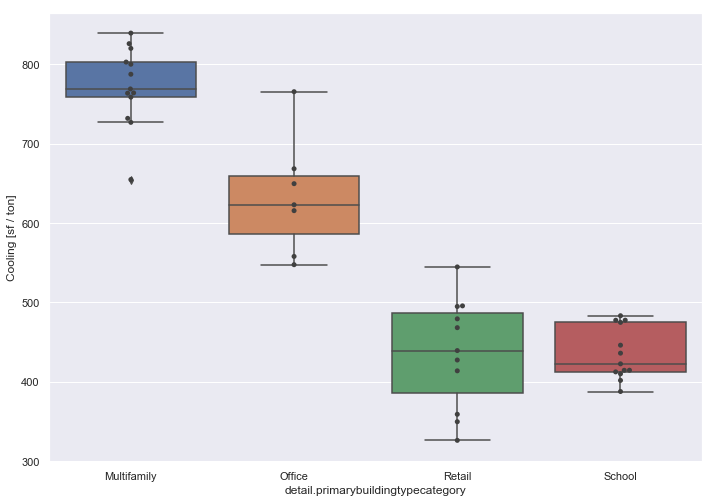

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y="Cooling [sf / ton]", data=ENV_GAIN, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y="Cooling [sf / ton]", data=ENV_GAIN)

# HEATING LOAD 

In [21]:
# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.siteid, SITE_DETAILS.totalconditionedfloorareaofallbuildings, SITE_DETAILS.totalgrossfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.[detail.primarybuildingtypecategory], SITE_DETAILS.city, '
sql_query += 'OVERALL_UA.[ua.total]FROM SITE_DETAILS LEFT JOIN OVERALL_UA '
sql_query += 'ON SITE_DETAILS.siteid = OVERALL_UA.siteid'

ENV_LOSS = pd.read_sql_query(sql_query, con)
ENV_LOSS = ENV_LOSS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN.

In [22]:
env_loss = []

# Envelope Loss Calculation
for i in range(0,len(ENV_LOSS)):
    env_loss.append((ENV_LOSS['ua.total'][i]*(t_stpt - t_oa_winter[ENV_LOSS['city'][i]])) / 1000)
    
ENV_LOSS['Heating Load - Envelope [kBtu]'] = env_loss

In [23]:
## SF PER kBtu CHECK

# Estimated Area
ENV_LOSS['EstAreaSF'] = ENV_LOSS.loc[:, ['totalconditionedfloorareaofallbuildings', 
                                     'totalgrossfloorareaofallbuildings']].min(axis = 1)

# Estimated kBtu / sf
ENV_LOSS['Heating [sf / kBtu]'] = ENV_GAIN['EstAreaSF'] / ENV_LOSS['Heating Load - Envelope [kBtu]']

## Calclulated Cooling Load vs Building Type - Envelope Load

In [24]:
ENV_LOSS.head()

,siteid,totalconditionedfloorareaofallbuildings,totalgrossfloorareaofallbuildings,detail.primarybuildingtypecategory,city,ua.total,Heating Load - Envelope [kBtu],EstAreaSF,Heating [sf / kBtu]
0,100016,122970.0,167806.0,Multifamily,Portland,8137.350761,382.455486,122970.0,321.527615
1,100201,NaN,87500.0,Office,Tualatin,7583.092000,356.405324,87500.0,245.506995
2,101127,49553.0,53434.0,Multifamily,Portland,5160.639796,242.550070,49553.0,204.300085
3,101959,140598.0,140598.0,Office,Portland,4275.508684,200.948908,140598.0,699.670385
4,102217,108792.0,108792.0,Retail,Albany,12540.126000,591.893947,108792.0,183.803197


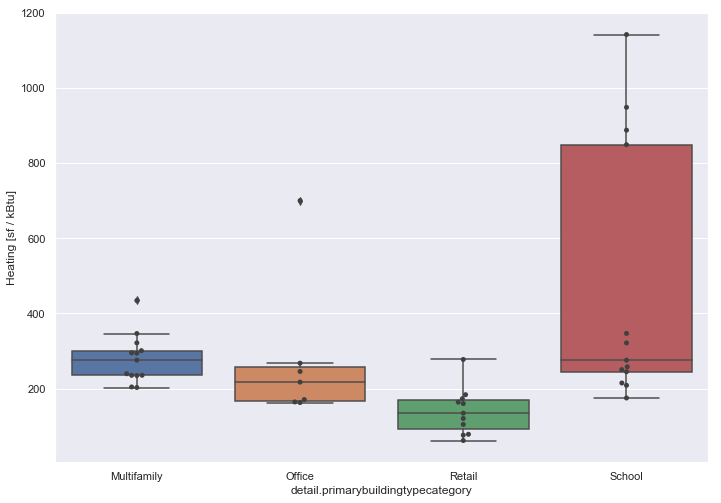

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y="Heating [sf / kBtu]", data=ENV_LOSS, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y="Heating [sf / kBtu]", data=ENV_LOSS)

# EQUIPMENT CAPACITIES

In [26]:
# Dictionaries used to support calculations

# Chillers and boiler carrier load in hydronic equipment, not the equipment themselves
# to avoid double counting, this dictionary is used as a multiplier
sources = {'None':0, 'Natural Gas':1, 'Hot Water':0, 'Electricity':1, 'Heat Pump or RCC':1, 
           'Condenser Water':0, 'Propane':1, 'Chilled Water':0, 'Chilled and Hot Water (cool/heat)':0}
# conversions to kBtu
conver = {'kBtu':1, 'mBh':1, 'kW':3.41, 'Btu':0.01, 'watts': 0.0341, 'tons':12, 'None':0, np.nan:0}

### AHUS

In [27]:
## AHUs
sql_query = 'SELECT siteid, hvaczoneid, qty, equiptype, heatingoutputcapacity, heatingoutputcapacityunits, heatingsource, coolingoutputcapacity, coolingoutputcapacityunits, coolingsource FROM AHUS'
AHUS = pd.read_sql_query(sql_query, con)
AHUS = AHUS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

heatSourceCounter = 0
coolSourceCounter = 0

adjustedHeatingCap = []
adjustedCoolingCap = []

n = 0

for i in range(0, len(AHUS)):
    # conversions to kBtu * sources dictionary elimates double counting * capacity * quantity
    adjustedHeatingCap.append(conver[AHUS['heatingoutputcapacityunits'][i]] * sources[AHUS['heatingsource'][i]] 
                              * AHUS['heatingoutputcapacity'][i] * AHUS['qty'][i])
    adjustedCoolingCap.append(conver[AHUS['coolingoutputcapacityunits'][i]] * sources[AHUS['coolingsource'][i]] 
                              * AHUS['coolingoutputcapacity'][i] * AHUS['qty'][i])
    
    n = n+1
    #print(n)
    
AHUS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
AHUS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap

AHUS.head()

,siteid,hvaczoneid,qty,equiptype,heatingoutputcapacity,heatingoutputcapacityunits,heatingsource,coolingoutputcapacity,coolingoutputcapacityunits,coolingsource,totalHeatingCapacity [kBtu],totalCoolingCapacity [kBtu]
0,100016,1.0,1.0,Gas Pack with AC,200.0,kBtu,Natural Gas,90.0,kBtu,Electricity,200.0,90.0
1,100016,1.0,1.0,Gas Pack with AC,200.0,kBtu,Natural Gas,90.0,kBtu,Electricity,200.0,90.0
2,100201,1.0,3.0,Gas Pack with AC,93.0,kBtu,Natural Gas,48.0,kBtu,Electricity,279.0,144.0
3,100201,1.0,6.0,Gas Pack with AC,59.0,kBtu,Natural Gas,60.0,kBtu,Electricity,354.0,360.0
4,100201,1.0,2.0,Gas Pack with AC,56.0,kBtu,Natural Gas,36.0,kBtu,Electricity,112.0,72.0


### BOILERS

In [28]:
## BOILERS
sql_query = 'SELECT siteid, hvaczoneid, qty, outputcapacity, capacityunits FROM BOILERS'
BOILERS = pd.read_sql_query(sql_query, con)

adjustedHeatingCap = []
for i in range(0, len(BOILERS)):
    adjustedHeatingCap.append(BOILERS['qty'][i] * BOILERS['outputcapacity'][i])
    
BOILERS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
BOILERS.head(row)

,siteid,hvaczoneid,qty,outputcapacity,capacityunits,totalHeatingCapacity [kBtu]
0,102938,2,2,1350,kBtu,2700
1,103148,1,2,2800,kBtu,5600
2,104111,None,1,379,kBtu,379
3,104148,None,2,2790,kBtu,5580
4,106207,multiple,4,2340,kBtu,9360
5,107643,1,2,1500,kBtu,3000
6,108503,1,2,1840,kBtu,3680
7,109933,2,2,920,kBtu,1840
8,112077,2,4,1900,kBtu,7600
9,112551,6,2,930,kBtu,1860


### CHILLERS

In [29]:
## CHILLERS
sql_query = 'SELECT siteid, hvaczoneid, qty, capacity, capacityunits FROM CHILLERS'
CHILLERS = pd.read_sql_query(sql_query, con)

adjustedCoolingCap = []
for i in range(0, len(CHILLERS)):
    adjustedCoolingCap.append(CHILLERS['qty'][i] * CHILLERS['capacity'][i])

CHILLERS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap
CHILLERS.head(row)

,siteid,hvaczoneid,qty,capacity,capacityunits,totalCoolingCapacity [kBtu]
0,102938,9,1,125.000,tons,125.000
1,106207,multiple,1,100.000,tons,100.000
2,107643,1,1,125.000,tons,125.000
3,108503,1,1,130.000,tons,130.000
4,112077,2,1,350.000,tons,350.000
5,112077,3,1,200.000,tons,200.000
6,112077,2,1,52.000,tons,52.000
7,113050,None,3,98.294,tons,294.882


### HPSACS

In [30]:
# HPSACS

sql_query = 'SELECT siteid, hvaczoneid, qty, heatingoutputcapacity, heatingoutputcapacityunits, coolingoutputcapacity, coolingoutputcapacityunits FROM HPSACS'
HPSACS = pd.read_sql_query(sql_query, con)

adjustedHeatingCap = []
adjustedCoolingCap = []

for i in range(0, len(HPSACS)):
    adjustedHeatingCap.append(HPSACS['qty'][i] * HPSACS['heatingoutputcapacity'][i])
    adjustedCoolingCap.append(HPSACS['qty'][i] * HPSACS['coolingoutputcapacity'][i])

HPSACS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
HPSACS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap
    
HPSACS.head(row)

,siteid,hvaczoneid,qty,heatingoutputcapacity,heatingoutputcapacityunits,coolingoutputcapacity,coolingoutputcapacityunits,totalHeatingCapacity [kBtu],totalCoolingCapacity [kBtu]
0,100016,4.0,3,25.5,kBtu,22.5,kBtu,76.5,67.5
1,100016,4.0,2,34.0,kBtu,24.0,kBtu,68.0,48.0
2,100016,4.0,1,54.0,kBtu,48.0,kBtu,54.0,48.0
3,100016,4.0,1,8.5,kBtu,7.5,kBtu,8.5,7.5
4,100016,3.0,58,NaN,mBh,6.0,kBtu,NaN,348.0
5,100016,3.0,8,NaN,mBh,9.0,kBtu,NaN,72.0
6,100016,3.0,3,NaN,mBh,12.0,kBtu,NaN,36.0
7,100016,6.0,2,NaN,mBh,30.0,kBtu,NaN,60.0
8,100201,1.0,1,NaN,None,24.0,kBtu,NaN,24.0
9,101127,1.0,7,8.1,kBtu,9.0,kBtu,56.7,63.0


### TERMINAL UNITS

In [31]:
sql_query = 'SELECT siteid, hvaczoneid, qty, fuel, heatingcapacity, heatingcapacityunits, coolingcapacity, coolingcapacityunits FROM TERMINALUNITS'
TERMINALUNITS = pd.read_sql_query(sql_query, con)
TERMINALUNITS = TERMINALUNITS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

adjustedHeatingCap = []
adjustedCoolingCap = []

for i in range(0, len(TERMINALUNITS)):
    # convert units * sources dictionary elimates double counting * capacity * quantity
    adjustedHeatingCap.append(conver[TERMINALUNITS['heatingcapacityunits'][i]] * sources[TERMINALUNITS['fuel'][i]]
                              * TERMINALUNITS['qty'][i] * TERMINALUNITS['heatingcapacity'][i])      
    adjustedCoolingCap.append(conver[TERMINALUNITS['coolingcapacityunits'][i]] * sources[TERMINALUNITS['fuel'][i]]
                              * TERMINALUNITS['qty'][i] * TERMINALUNITS['coolingcapacity'][i])
        
TERMINALUNITS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
TERMINALUNITS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap

TERMINALUNITS.head(row)

,siteid,hvaczoneid,qty,fuel,heatingcapacity,heatingcapacityunits,coolingcapacity,coolingcapacityunits,totalHeatingCapacity [kBtu],totalCoolingCapacity [kBtu]
0,100016,2.0,165.0,Electricity,2.00,kW,NaN,None,1125.3000,NaN
1,100016,2.0,193.0,Electricity,0.50,kW,NaN,None,329.0650,NaN
2,100201,2.0,1.0,Natural Gas,150000.00,Btu,NaN,None,1500.0000,NaN
3,100201,2.0,1.0,Natural Gas,75000.00,Btu,NaN,None,750.0000,NaN
4,101127,4.0,1.0,Electricity,1.00,kW,NaN,None,3.4100,NaN
5,101127,5.0,1.0,Electricity,1.00,kW,NaN,None,3.4100,NaN
6,101127,5.0,1.0,Electricity,2.25,kW,NaN,None,7.6725,NaN
7,101127,5.0,1.0,Electricity,0.75,kW,NaN,None,2.5575,NaN
8,101127,3.0,1.0,Electricity,1.50,kW,NaN,None,5.1150,NaN
9,101127,5.0,1.0,Electricity,1.50,kW,NaN,None,5.1150,NaN


In [32]:
## CREATE SUMMATION DATAFRAME - CAPACITIES

# Goupby Sites
# this step makes all dfs siteid indexed
AHUS = AHUS.groupby('siteid').sum()
BOILERS = BOILERS.groupby('siteid').sum()
CHILLERS = CHILLERS.groupby('siteid').sum()
HPSACS = HPSACS.groupby('siteid').sum()
TERMINALUNITS = TERMINALUNITS.groupby('siteid').sum()

In [33]:
# Create DataFrame of Sites

# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.totalconditionedfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.totalgrossfloorareaofallbuildings, ' 
sql_query += 'siteid, stratum, city, SITE_DETAILS.[detail.primarybuildingtypecategory] FROM SITE_DETAILS'

CAPACITIES = pd.read_sql_query(sql_query, con)
CAPACITIES = CAPACITIES.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

In [34]:
# Map to dictionaries to add to dataframes

# AHUS
ahu_heating = dict(zip(AHUS.index.tolist(),AHUS['totalHeatingCapacity [kBtu]'].tolist()))
ahu_cooling = dict(zip(AHUS.index.tolist(),AHUS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['AHUS_heating [kBtu]'] = CAPACITIES['siteid'].map(ahu_heating)
CAPACITIES['AHUS_cooling [kBtu]'] = CAPACITIES['siteid'].map(ahu_cooling)

# BOILERS
boiler_heating = dict(zip(BOILERS.index.tolist(),BOILERS['totalHeatingCapacity [kBtu]'].tolist()))
CAPACITIES['BOILERS_heating [kBtu]'] = CAPACITIES['siteid'].map(boiler_heating)

# CHILLERS
chiller_cooling = dict(zip(CHILLERS.index.tolist(),CHILLERS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['CHILLERS_cooling [kBtu]'] = CAPACITIES['siteid'].map(chiller_cooling)

# HPSACS
HP_heating = dict(zip(HPSACS.index.tolist(),HPSACS['totalHeatingCapacity [kBtu]'].tolist()))
HP_cooling = dict(zip(HPSACS.index.tolist(),HPSACS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['HPSACS_heating [kBtu]'] = CAPACITIES['siteid'].map(HP_heating)
CAPACITIES['HPSACS_cooling [kBtu]'] = CAPACITIES['siteid'].map(HP_cooling)

# TERMINALUNITS
TERM_heating = dict(zip(TERMINALUNITS.index.tolist(),TERMINALUNITS['totalHeatingCapacity [kBtu]'].tolist()))
TERM_cooling = dict(zip(TERMINALUNITS.index.tolist(),TERMINALUNITS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['TERMINALUNITS_heating [kBtu]'] = CAPACITIES['siteid'].map(TERM_heating)
CAPACITIES['TERMINALUNITS_cooling [kBtu]'] = CAPACITIES['siteid'].map(TERM_cooling)

In [35]:
CAPACITIES['totalHeatingCapacity [kBtu]'] = (CAPACITIES['AHUS_heating [kBtu]'].replace(np.nan, 0) + 
                                             CAPACITIES['BOILERS_heating [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['HPSACS_heating [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['TERMINALUNITS_heating [kBtu]'].replace(np.nan, 0))

CAPACITIES['totalCoolingCapacity [kBtu]'] = (CAPACITIES['AHUS_cooling [kBtu]'].replace(np.nan, 0) + 
                                             CAPACITIES['CHILLERS_cooling [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['HPSACS_cooling [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['TERMINALUNITS_cooling [kBtu]'].replace(np.nan, 0))  

In [36]:
## SF PER kBtu CHECK

# Estimated Area
CAPACITIES['EstAreaSF'] = CAPACITIES.loc[:, ['totalconditionedfloorareaofallbuildings', 
                                     'totalgrossfloorareaofallbuildings']].min(axis = 1)

cool = []
heat = []

for i in range(0, len(CAPACITIES)):
    if CAPACITIES['totalHeatingCapacity [kBtu]'][i] > 5:
        # Estimated sf / kBtu
        heat.append(CAPACITIES['EstAreaSF'][i] / CAPACITIES['totalHeatingCapacity [kBtu]'][i])
    else:
        heat.append(np.nan)
    if CAPACITIES['totalCoolingCapacity [kBtu]'][i] > 5:
        # Estimated sf / ton
        cool.append(CAPACITIES['EstAreaSF'][i] / (CAPACITIES['totalCoolingCapacity [kBtu]'][i]/12))
    else:
        cool.append(np.nan)

CAPACITIES['Heating [sf / kBtu]'] = heat
CAPACITIES['Cooling [sf / ton]'] = cool

CAPACITIES.head()

,totalconditionedfloorareaofallbuildings,totalgrossfloorareaofallbuildings,siteid,stratum,city,detail.primarybuildingtypecategory,AHUS_heating [kBtu],AHUS_cooling [kBtu],BOILERS_heating [kBtu],CHILLERS_cooling [kBtu],HPSACS_heating [kBtu],HPSACS_cooling [kBtu],TERMINALUNITS_heating [kBtu],TERMINALUNITS_cooling [kBtu],totalHeatingCapacity [kBtu],totalCoolingCapacity [kBtu],EstAreaSF,Heating [sf / kBtu],Cooling [sf / ton]
0,122970.0,167806.0,100016,Multifamily 3,Portland,Multifamily,400.0,180.0,NaN,NaN,207.0,687.0,1454.365,0.0,2061.365,867.0,122970.0,59.654646,1702.006920
1,NaN,87500.0,100201,Office 4,Tualatin,Office,745.0,576.0,NaN,NaN,0.0,24.0,2250.000,0.0,2995.000,600.0,87500.0,29.215359,1750.000000
2,49553.0,53434.0,101127,Multifamily 1,Portland,Multifamily,186.0,89.0,NaN,NaN,653.9,765.0,217.217,0.0,1057.117,854.0,49553.0,46.875606,696.295082
3,140598.0,140598.0,101959,Office 2,Portland,Office,1296.0,766.0,NaN,NaN,1296.0,1152.0,0.000,0.0,2592.000,1918.0,140598.0,54.243056,879.653806
4,108792.0,108792.0,102217,Retail 5,Albany,Retail,2656.0,2718.0,NaN,NaN,NaN,NaN,NaN,NaN,2656.000,2718.0,108792.0,40.960843,480.317881


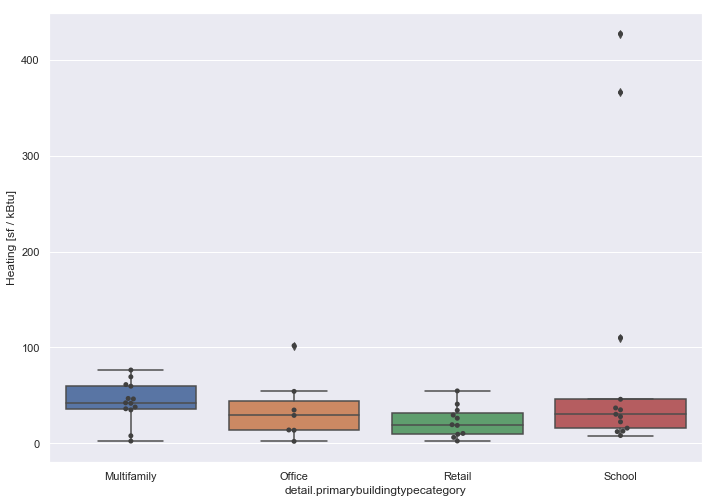

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES)

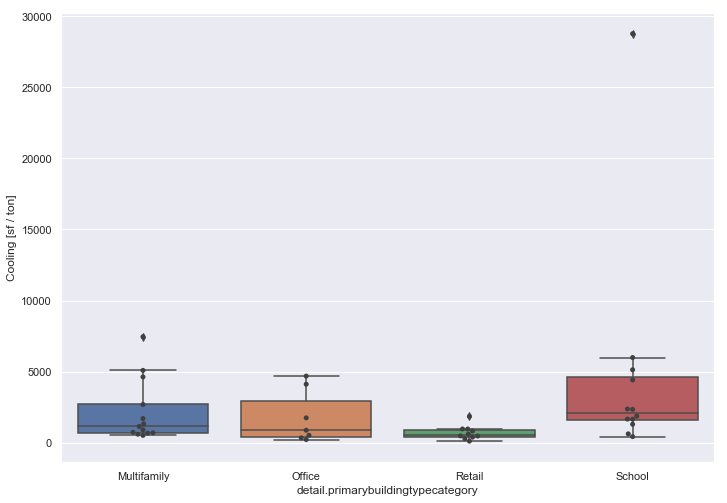

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y='Cooling [sf / ton]', data=CAPACITIES, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y='Cooling [sf / ton]', data=CAPACITIES)